In [1]:
from scipy import interpolate
import gsw
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

### Dask Cluster

In [53]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=10)
cluster.scale(4)

client = Client(cluster)
cluster

### Gridded monthly mean Argo data

In [66]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
# ds = xr.open_dataset(url) #,chunks={'lat': 90, 'lon': 90, 'time': -1}
ds = xr.open_dataset(url,chunks={'lat': 45, 'lon': 90, 'time': -1}) 
# ds = xr.open_dataset(url,chunks={'lat': 10, 'lon': 10, 'time': -1}) 
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 dask.array<shape=(180, 27, 180, 360), chunksize=(180, 27, 45, 90)>
    salt     (time, lev, lat, lon) float32 dask.array<shape=(180, 27, 180, 360), chunksize=(180, 27, 45, 90)>
    ptemp    (time, lev, lat, lon) float32 dask.array<shape=(180, 27, 180, 360), chunksize=(180, 27, 45, 90)>
    pden     (time, lev, lat, lon) float32 dask.array<shape=(180, 27, 180, 360), chunksize=(180, 27, 45, 90)>
    addep    (time, lev, lat, lon) float32 dask.array<shape=(180, 27, 180, 360), chunksize=(180, 27, 45, 90)>
    spice    (time, lev, lat, lon) f

In [67]:
ds.pden

<xarray.DataArray 'pden' (time: 180, lev: 27, lat: 180, lon: 360)>
dask.array<shape=(180, 27, 180, 360), dtype=float32, chunksize=(180, 27, 45, 90)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:  argo potential density (kg/m3) 

### Function for computing isopycnal depth

In [68]:
def compute_iso(pden, iso, z):

    dep_iso = np.zeros((pden.shape[1], pden.shape[2]))
    dep_iso[:, :] = np.nan
    for i in np.arange(0, pden.shape[2], 1):
        for j in np.arange(0, pden.shape[1], 1):

            den_tmp = pden[:, j, i]

            id1 = np.where(den_tmp < iso)

            if np.size(id1) > 0 and np.size(id1) < len(z):

                den1 = den_tmp[id1[0][-1]]
                den2 = den_tmp[id1[0][-1] + 1]

                if den1 < den2:
                    fun2 = interpolate.interp1d([den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                    dep_iso[j, i] = fun2(iso)

    return dep_iso

In [69]:
%%time
# pden = ds.sel(lat=slice(40,80),lon=slice(100,140)).pden
pden = ds.pden
z = pden.lev.values
iso = [24]

size = pden.shape
dep_iso = np.zeros((size[0], size[2], size[3]))
# for t in np.arange(size[0]):
for t in np.arange(1):
    data = pden[t, :, :, :].values
    dep_iso[t, :, :] = compute_iso(data, iso, z)
    #print(str(pden.time[t].values))
    
ds_dep_iso = xr.DataArray(dep_iso, coords={'time': pden.time, 'lat': pden.lat, 'lon': pden.lon}, dims=['time', 'lat', 'lon'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 6.29 s, sys: 1.58 s, total: 7.87 s
Wall time: 12.4 s


### Dask speed up

In [27]:
%%time
pden = ds.sel(lat=slice(40,80),lon=slice(100,140)).pden
z = pden.lev.values
iso = [24]

size = pden.shape
dep_iso = np.zeros((size[0], size[2], size[3]))
for t in np.arange(size[0]):
#for t in np.arange(1):
    data = pden[t, :, :, :].values
    dep_iso[t, :, :] = compute_iso(data, iso, z)
    #print(str(pden.time[t].values))
    
ds_dep_iso = xr.DataArray(dep_iso, coords={'time': pden.time, 'lat': pden.lat, 'lon': pden.lon}, dims=['time', 'lat', 'lon'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 10.6 s, sys: 1.5 s, total: 12.1 s
Wall time: 45.7 s


In [22]:
pden.lev

<xarray.DataArray 'lev' (lev: 27)>
array([   0.,    5.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,
        200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
       1100., 1200., 1300., 1400., 1500., 1750., 2000.])
Coordinates:
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
Attributes:
    units:          meters
    positive:       down
    name:           Depth
    grads_dim:      z
    grads_mapping:  levels
    long_name:      altitude
    minimum:        0.0
    maximum:        2000.0
    resolution:     76.92308

In [18]:
ds_dep_iso

<xarray.DataArray (time: 180, lat: 40, lon: 40)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lat      (lat) float64 40.5 41.5 42.5 43.5 44.5 ... 75.5 76.5 77.5 78.5 79.5
  * lon      (lon) float64 100.5 101.5 102.5 103.5 ... 136.5 137.5 138.5 139.5

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: No contour levels were found within the data range.
  


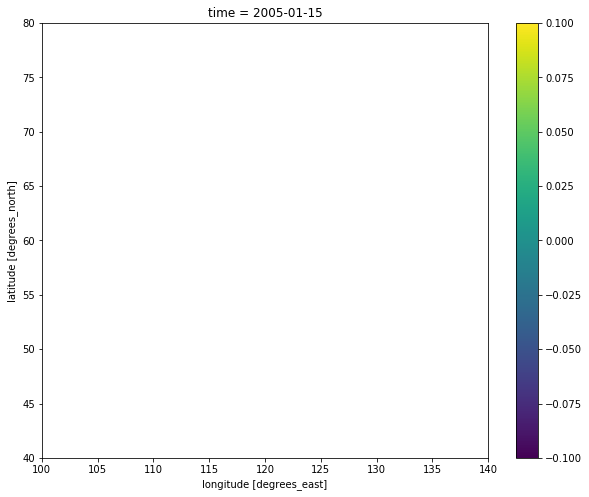

In [20]:
ds_dep_iso[0, :, :].plot(figsize=(10, 8))
plt.contour(pden.lon, pden.lat, ds_dep_iso[170, :, :], colors='k')

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


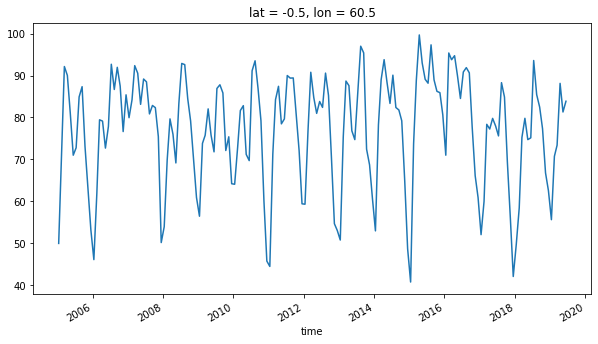

In [6]:
ds_dep_iso[:, 40, 20].plot(figsize=(10, 5))